In [1]:
!pip install opencv-python-headless matplotlib numpy easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 23.6 MB/s eta 0:00:00


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.3 MB/s eta 0:00:00


In [3]:
!pip install easyocr

In [6]:
import os
import zipfile
import shutil
import glob
import xml.etree.ElementTree as ET
import cv2
from matplotlib import pyplot as plt
import random
from ultralytics import YOLO
import numpy as np
from PIL import Image
import easyocr
from collections import Counter

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
zip_path =r"E:\ANPR_DATASET.zip"
extract_dir="ANPR_DATASET"

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
zip_path =r"/content/drive/MyDrive/ANPR_DATASET.zip"
extract_dir="ANPR_DATASET"

In [19]:
if os.path.exists(extract_dir):
  shutil.rmtree(extract_dir)
with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall(extract_dir)
print("Dataset extracted successfully in:", extract_dir)
print("Folders inside:", os.listdir(extract_dir))

Dataset extracted successfully in: ANPR_DATASET
Folders inside: ['annotations', 'images']


In [20]:
images_path = os.path.join(extract_dir,"images")
annotations_path = os.path.join(extract_dir,"annotations")

print("images folder:",os.path.exists(images_path))
print("annotations folder:",os.path.exists(annotations_path))


images folder: True
annotations folder: True


In [21]:
sample_images = glob.glob(os.path.join(images_path,"*.png"))
sample_annotations = glob.glob(os.path.join(annotations_path,"*.xml"))
print(f"sample images:",len(sample_images))
print(f"sample annotations:",len(sample_annotations))
print("\nSample image file:", sample_images[0])
print("Sample annotation file:", sample_annotations[0])

sample images: 433
sample annotations: 433

Sample image file: ANPR_DATASET/images/Cars109.png
Sample annotation file: ANPR_DATASET/annotations/Cars381.xml


In [22]:
sample_xml = "ANPR_DATASET/annotations/Cars59.xml"
tree  = ET.parse(sample_xml)
root = tree.getroot()
print("Filename:",root.find("filename").text)
for obj in root.findall("object"):
  print("class:", obj.find('name').text)
  bndbox = obj.find("bndbox")
  print("bndbox:",bndbox.find("xmin").text,bndbox.find("ymin").text,bndbox.find("xmax").text,bndbox.find("ymax").text)

Filename: Cars59.png
class: licence
bndbox: 324 162 375 175


In [23]:
Sample_img_path = "ANPR_DATASET/images/Cars0.png"
sample_xml_path = "ANPR_DATASET/annotations/Cars0.xml"

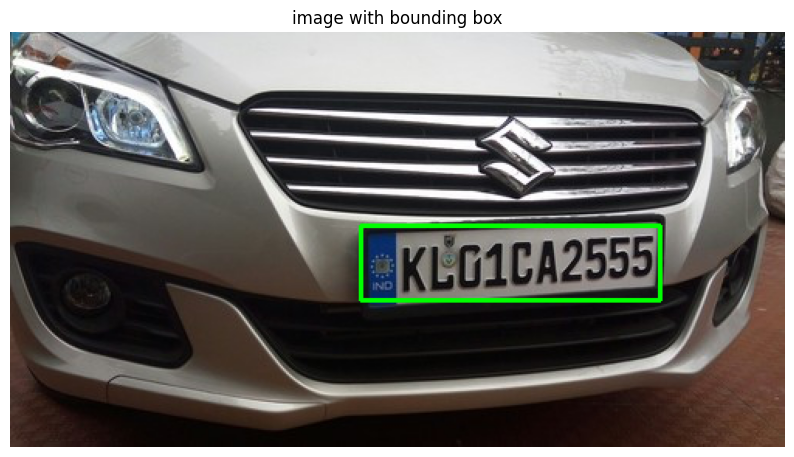

In [24]:
img = cv2.imread(Sample_img_path)
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#ET.parse() reads and loads an XML file into a tree structure
tree = ET.parse(sample_xml_path)
root = tree.getroot()

for obj in root.findall("object"):
  bndbox = obj.find("bndbox")
  xmin = int(bndbox.find("xmin").text)
  ymin = int(bndbox.find("ymin").text)
  xmax = int(bndbox.find("xmax").text)
  ymax = int(bndbox.find("ymax").text)
  cv2.rectangle(img_rgb,(xmin,ymin),(xmax,ymax),(0,255,0),2)
  plt.figure(figsize=(10,10))
  plt.imshow(img_rgb)
  plt.axis("off")
  plt.title("image with bounding box")
  plt.show()

In [26]:
images_path = "ANPR_DATASET/images"
annotations_path = "ANPR_DATASET/annotations"

images = glob.glob(os.path.join(images_path,"*.png"))
random.seed(42)# randomness shuffling data
random.shuffle(images)
#train test split ratio
split_ratio = 0.8
split_index = int(split_ratio*len(images))
train_images = images[:split_index]
val_images = images[split_index:]

train_dir = "dataset/train"
val_dir = "dataset/val"
#A for loop repeats a block of code for each item in a sequence.
for folder in [train_dir,val_dir]:
  for sub in ["images","annotations"]:
    os.makedirs(os.path.join(folder,sub),exist_ok=True)

def move_files(image_list,dest_folder):
  for img_path in image_list:
    filename = os.path.basename(img_path)
    shutil.copy(img_path,os.path.join(dest_folder,"images",filename))
    xml_name = filename.replace(".png",".xml")
    xml_path = os.path.join(annotations_path,xml_name)
    if os.path.exists(xml_path):
      shutil.copy(xml_path,os.path.join(dest_folder,"annotations",xml_name))

move_files(train_images,train_dir)
move_files(val_images,val_dir)
print("Train/Validation split done!")

Train/Validation split done!



image 1/1 /content/ANPR_DATASET/images/Cars0.png: 352x640 1 car, 1163.9ms
Speed: 10.8ms preprocess, 1163.9ms inference, 69.8ms postprocess per image at shape (1, 3, 352, 640)


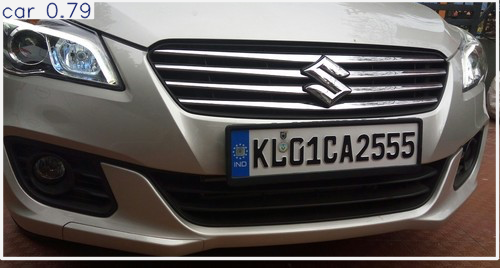

In [27]:
model = YOLO("yolov8s.pt")
result=model(Sample_img_path)
result[0].show()

In [28]:
def convert_xml_to_yolo(xml_file,img_width,img_height):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  yolo_lines = []
  for obj in root.findall("object"):
    class_id = 0
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    x_center = (xmin+xmax)/(2*img_width)
    y_center = (ymin+ymax)/(2*img_height)
    width = (xmax-xmin)/img_width
    height = (ymax-ymin)/img_height
    yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")
  return yolo_lines

In [29]:
def process_folder(folder_path):
    img_folder = os.path.join(folder_path,"images")
    ann_folder = os.path.join(folder_path,"annotations")
    yolo_folder = os.path.join(folder_path,"labels")
    os.makedirs(yolo_folder,exist_ok=True)
    img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(".png")]
    for img_file in img_files:
        img_path = os.path.join(img_folder,img_file)
        ann_file = img_file.replace(".png",".xml")
        ann_path = os.path.join(ann_folder,ann_file)
        with Image.open(img_path) as im:
            width,height = im.size
        if os.path.exists(ann_path):
            yolo_lines = convert_xml_to_yolo(ann_path,width,height)
        else:
            yolo_lines = []
        txt_file = os.path.join(yolo_folder,img_file.replace(".png",".txt"))
        with open (txt_file,"w") as f:
            f.write("\n".join(yolo_lines))

In [30]:
process_folder(train_dir)
process_folder(val_dir)
print("XML annotations converted to YOLO labels")

XML annotations converted to YOLO labels


In [31]:
dataset_yaml = """
path: .
train: dataset/train/images
val: dataset/val/images
nc: 1
names: ['licence']
"""
with open("car_plate_dataset.yaml","w") as f:
  f.write(dataset_yaml)
  print("yaml file saved successfully")

yaml file saved successfully


In [32]:
model = YOLO("yolov8n.pt")
model.train(
    data = "car_plate_dataset.yaml",
    epochs = 20,
    imgsz = 640,
    batch = 4,
    name = "car_plate_detection"
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car_plate_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_plate_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x791222730b00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [33]:
val_images_dir = os.path.join("dataset/val/images")
val_image_filenames = [f for f in os.listdir(val_images_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
test_img_path = os.path.join(val_images_dir,random.choice(val_image_filenames))
print("testing on image:" ,test_img_path)

testing on image: dataset/val/images/Cars332.png



image 1/1 /content/dataset/val/images/Cars332.png: 384x640 1 licence, 168.5ms
Speed: 3.0ms preprocess, 168.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


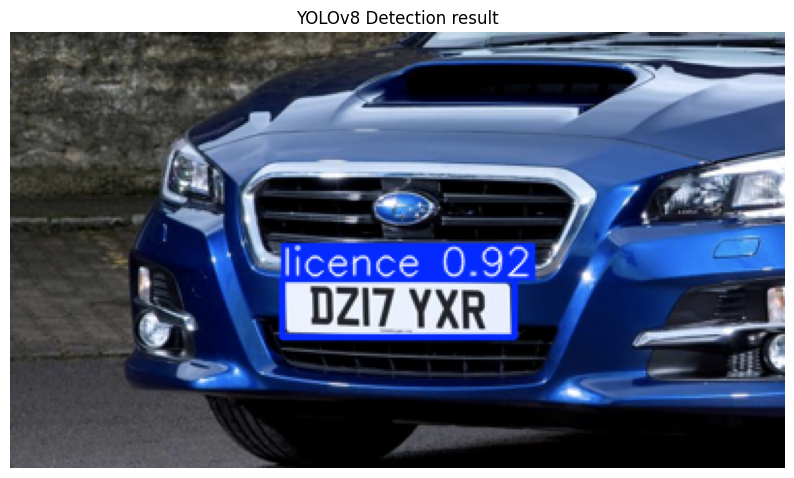

In [34]:
results = model.predict(test_img_path)
results[0].plot()
img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection result")
plt.show()



Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
image 1/1 /content/dataset/val/images/Cars332.png: 384x640 1 licence, 376.8ms
Speed: 7.6ms preprocess, 376.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Detected number plate text: [([[np.int32(12), 0], [np.int32(112), 0], [np.int32(112), 30], [np.int32(12), 30]], 'DZI7 YXR', np.float64(0.694537327451057))]


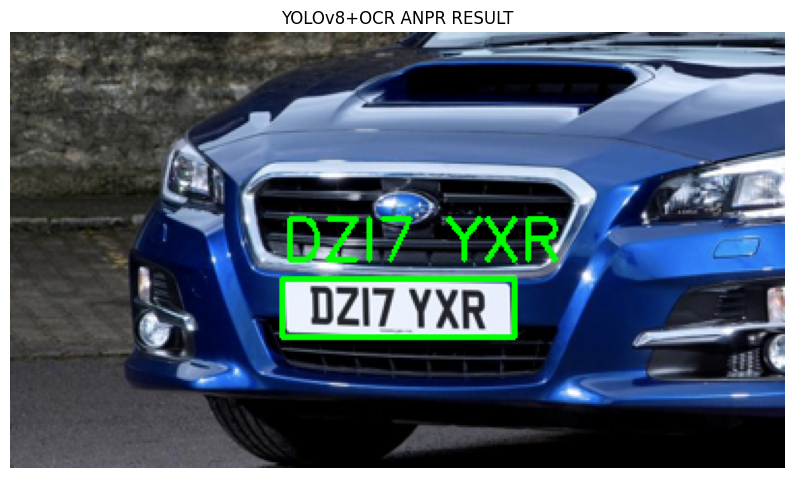

In [35]:
reader = easyocr.Reader(['en'])
img = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

results = model.predict(test_img_path)[0]

plate_texts = []
confidences = []

for i, box in enumerate(results.boxes.xyxy):
  xmin, ymin,xmax,ymax = map(int,box.cpu().numpy())
  plate_img = img[ymin:ymax,xmin:xmax]
  ocr_result = reader.readtext(plate_img)
  print("Detected number plate text:",ocr_result)
  cv2.rectangle(img_rgb,(xmin,ymin),(xmax,ymax),(0,255,0),2)
  if ocr_result:
    text = ocr_result[0][1]
    plate_texts.append(text)
    confidences.append(results.boxes.conf[i].item())
    cv2.putText(img_rgb,text,(xmin,ymin-10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    plt.figure(figsize=(10,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("YOLOv8+OCR ANPR RESULT")
    plt.show()

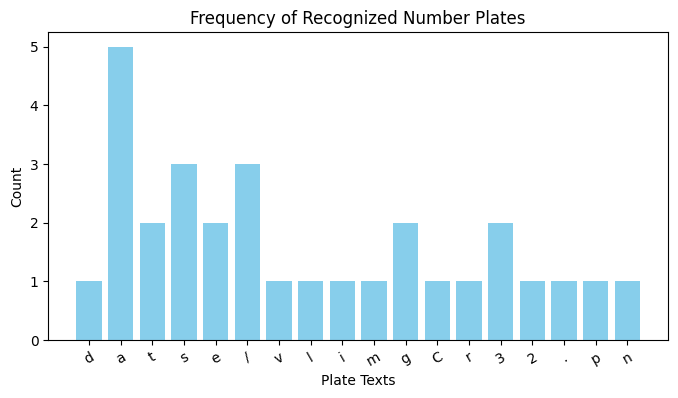

In [36]:
freq = Counter(test_img_path)
plt.figure(figsize=(8,4))
plt.bar(freq.keys(), freq.values(), color="skyblue")
plt.title("Frequency of Recognized Number Plates")
plt.xlabel("Plate Texts")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

In [45]:
val_images_dir = "dataset/val/images"

val_image_filenames = [
    f for f in os.listdir(val_images_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

val_image_filenames = sorted(val_image_filenames)

yolo_conf_scores = []
ocr_texts = []

for filename in val_image_filenames:
    img_path = os.path.join(val_images_dir, filename)

    results = model.predict(img_path, verbose=False)[0]

    if len(results.boxes) > 0:
        best_conf = float(results.boxes.conf.max().cpu().numpy())
        yolo_conf_scores.append(best_conf)
    else:
        yolo_conf_scores.append(0)

print("Total images processed:", len(yolo_conf_scores))
print("First 10 confidence scores:", yolo_conf_scores[:10])

Total images processed: 87
First 10 confidence scores: [0.3744838833808899, 0.8348776698112488, 0.8243108987808228, 0, 0.8311653137207031, 0.7412317395210266, 0.5148288607597351, 0.8246936202049255, 0.8433073163032532, 0.6373332142829895]


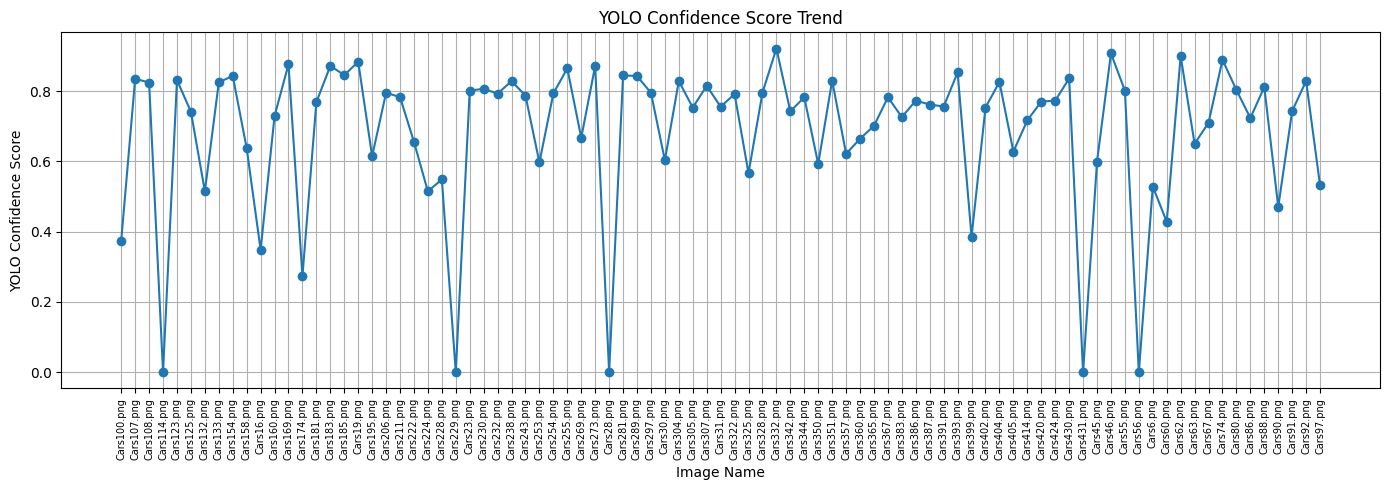

In [47]:
plt.figure(figsize=(14,5))
plt.plot(val_image_filenames, yolo_conf_scores, marker='o')
plt.title("YOLO Confidence Score Trend")
plt.xlabel("Image Name")
plt.ylabel("YOLO Confidence Score")
plt.xticks(rotation=90, fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()
